In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


**Goal:** Which factor amongst `['yr_construction', 'period_op', 'months in use'] contributes most to the number of damages that a ship incurs?

**Method:** Poisson regression - they key here is that the likelihood function is a Poisson likelihood, to model counts.

In [2]:
df = pd.read_csv('datasets/ship-damage.txt')
# Log10 transform months
df['months'] = df['months'].apply(lambda x: np.log10(x))
df.head()

,type,yr_construction,period_op,months,n_damages
0,1,1,1,2.103804,0
1,1,1,2,1.799341,0
2,1,2,1,3.039414,3
3,1,2,2,3.039414,4
4,1,3,1,3.179552,6


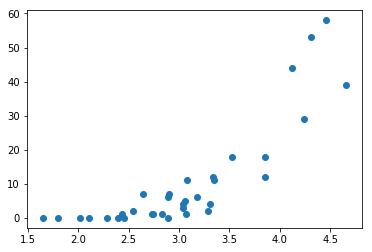

In [3]:
plt.scatter(x=df['months'], y=df['n_damages'])

In [4]:
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sd=100**2, shape=(3, 1))    
    n_damages = betas[0] * df['yr_construction'] + betas[1] * df['period_op'] + betas[2] * df['months']
        
    n_damages_like = pm.Poisson('likelihood', mu=np.exp(n_damages), observed=df['n_damages'])
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -195.97: 100%|██████████| 200000/200000 [00:08<00:00, 22408.07it/s]
Finished [100%]: Average ELBO = -195.98
100%|██████████| 2000/2000 [00:04<00:00, 436.95it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fceb1c6af60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fce92380b70>]], dtype=object)

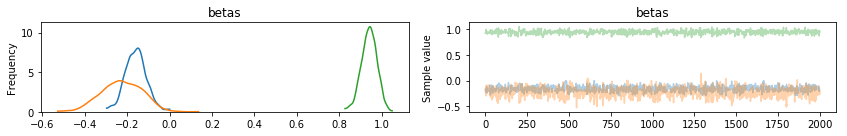

In [5]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce996f79b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fce996777f0>], dtype=object)

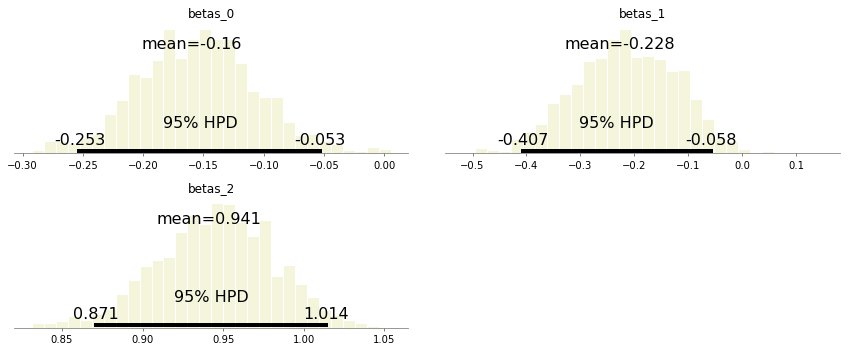

In [6]:
pm.plot_posterior(trace, color='beige', )

In [7]:
pm.summary(trace)


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  -0.160           0.050            0.002            [-0.253, -0.053]
  ..............................[1, :]...............................
  -0.228           0.094            0.004            [-0.407, -0.058]
  ..............................[2, :]...............................
  0.941            0.037            0.001            [0.871, 1.014]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  .............................[0, :].............................
  -0.261         -0.193         -0.160         -0.128         -0.055
  .............................[1, :].............................
  -0.410         -0.293         -0.227         -0.157         -0.060
  ....